In [131]:
!pip install tsai
import pandas as pd
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy.random as npr

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


# Data preparation

In [16]:
df = pd.read_csv("5sec_intervals_no_na_normed.csv")
df = df[['PRICE', 'SIZE', 'vol']]
df.head()

,PRICE,SIZE,vol
0,-1.713467,0.000773,2.098651
1,-1.719555,0.036915,2.068303
2,-1.718412,0.048620,2.006872
3,-1.720527,0.095456,1.834030
4,-1.719023,0.023657,1.833023


In [36]:
train_data = df[:round(0.8 * len(df))].copy()
test_data = df[train_data.iloc[-1].name+1:]

In [65]:
train_data[:120]

,PRICE,SIZE,vol
0,-1.713467,0.000773,2.098651
1,-1.719555,0.036915,2.068303
2,-1.718412,0.048620,2.006872
3,-1.720527,0.095456,1.834030
4,-1.719023,0.023657,1.833023
...,...,...,...
115,-1.714687,-0.006404,1.818437
116,-1.718210,0.009351,1.817190
117,-1.716480,0.062125,1.818805
118,-1.717838,-0.020977,1.809160


In [50]:
train_data_normalized = torch.FloatTensor(train_data.to_numpy().tolist())
test_data_normalized = torch.FloatTensor(test_data.to_numpy().tolist())

In [58]:
test_data_normalized[:, 2]

tensor([-0.6298, -0.6214, -0.6266,  ...,  0.5650,  0.5892,  0.6046])

In [119]:
def create_inout_sequences(input_data, tw, sl):
    """
    tw: train_window
    sl: sequence_length
    """
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw-sl):
        train_seq = input_data[i:i+tw]
        # Select the volatility column
        train_label = input_data[i+tw:i+tw+sl, 2]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 100
pred_seq_len = 20

# Prepare sequences
train_sequence = create_inout_sequences(train_data.to_numpy(), train_window, pred_seq_len)
test_sequence = create_inout_sequences(test_data.to_numpy(), train_window, pred_seq_len)

# Training Utilities

In [121]:
def get_batch(x, y, batch_size):
    """
    Generator that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = np.array(x[i : i + batch_size])
        batch_y = np.array(y[i : i + batch_size])
        yield (batch_x, batch_y)

In [124]:
train_x = [t[0] for t in train_sequence]
train_y = [t[1] for t in train_sequence]

batches = get_batch(train_x, train_y, 64)

In [130]:
def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)


def run_validation_step(
    model,
    criterion,
    inputs,
    labels,
    batch_size,
    args,
    plotpath=None,
    visualize=True,
    downsize_input=False
):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(inputs, labels, batch_size)):
        inputs, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = model(inputs)

        val_loss = criterion(outputs, labels)
        losses.append(val_loss.data.item())

        # _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()

#     if plotpath:  # only plot if a path is provided
#         plot(
#             xs,
#             ys,
#             predicted.cpu().numpy(),
#             colours,
#             plotpath,
#             visualize=visualize,
#             compare_bilinear=downsize_input,
#         )

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
        
def train(args, model=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True, encoding="bytes")[0]
    num_colours = np.shape(colours)[0]
    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if model is None:
        Net = globals()[args.model]
        model = Net(args.kernel, args.num_filters, num_colours, num_in_channels)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        model.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb_cat, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)

            loss = compute_loss(
                criterion, outputs, labels, batch_size=args.batch_size, num_colours=num_colours
            )
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())


        # Evaluate the model
        model.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc = run_validation_step(
            model,
            criterion,
            test_grey,
            test_rgb_cat,
            args.batch_size,
            colours,
            save_dir + "/test_%d.png" % epoch,
            args.visualize,
            args.downsize_input,
        )

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print(
            "Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f"
            % (epoch + 1, args.epochs, val_loss, val_acc, time_elapsed)
        )

    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/training_curve.png")

    if args.checkpoint:
        print("Saving model...")
        torch.save(model.state_dict(), args.checkpoint)

    return model

# Model definition

In [2]:
# TCN IMPLEMENTATION

# Bai, S., Kolter, J. Z., & Koltun, V. (2018). An empirical evaluation of generic convolutional and recurrent networks for sequence modeling. arXiv preprint arXiv:1803.01271.
# Official TCN PyTorch implementation: https://github.com/locuslab/TCN

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [83]:
import torch.nn.functional as F
from torch import nn

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        y1 = self.tcn(inputs)  # input should have dimension (N, C, L)
        o = self.linear(y1[:, :, -1])
        return o

In [132]:
# Model that uses TCN

class VolForecast(nn.Module):
    def __init__(self, seq_len, input_size, output_size=1):
        super(VolForecast, self).__init__()
        self.seq_len = seq_len
        self.input_size = input_size
        self.output_size = output_size

        self.tcn = TCN(input_size=input_size, output_size=output_size, num_channels=8*[25], kernel_size=7, dropout=0.1)
  
    def forward(self, x):
        return self.tcn(x)

In [ ]:
# Train the simple TCN block model

train_window = 100
pred_seq_len = 20

args = AttrDict()
args_dict = {
    "gpu": False,
    "valid": False,
    "checkpoint": "",
    "sequence_len": train_window,
    "output_size": pred_seq_len,
    "model": "TCN_simple",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 64,
    "epochs": 50,
    "seed": 0,
    "plot": False,
    "experiment_name": "simple_TCN_volatility",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
 = train(args)

In [84]:
import math

def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

def get_data_single_horizon(file_name, seq_len, horizon, input_fields, output_fields, val_ratio=0.01):
    # Get data from csv
    df = pd.read_csv(file_name)
    inputs = df_to_tensor(df[input_fields])
    outputs = df_to_tensor(df[output_fields])
    
    # Group seq_len concecutive input points together, and horizon concecutive output vectors together
    inputs = torch.stack([inputs[i:i - seq_len - horizon] for i in range(seq_len)], dim = 1)
    outputs = outputs[seq_len + horizon:]

    assert len(inputs) == len(outputs), f"Input and output arrays have different lengths: {len(inputs)} \= {len(outputs)}"
    
    # Do train/validation split
    val_len = math.ceil(val_ratio * len(inputs))
    train_x = inputs[:-val_len].transpose(1,2)
    train_y = outputs[:-val_len]
    val_x = inputs[-val_len:].transpose(1,2)
    val_y = outputs[-val_len:]

    print("Train input dimension:", train_x.shape)
    print("Train output dimension:", train_y.shape)
    print("Validation input dimension:", val_x.shape)
    print("Validation output dimension:", val_y.shape)

    return train_x, train_y, val_x, val_y

In [7]:
from pandas.core.dtypes.cast import validate_numeric_casting
import torch.optim as optim

def train(model, opts, train_x, train_y, val_x, val_y):
    loss_fn = nn.MSELoss()
    batch_size = opts['batch_size']
    validation_period = opts['validation_period']

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(opts['nepochs']):
        # Sample batch input randomly
        random_ids = np.random.randint(len(train_x), size=batch_size)
        train_input = train_x[random_ids]
        train_output = train_y[random_ids]        

        optimizer.zero_grad()
        loss = loss_fn(model(train_input), train_output)
        loss.backward()
        optimizer.step()
        train_losses += [loss]

        if (epoch+1) % validation_period == 0:

            val_loss = loss_fn(model(val_x), val_y)
            val_losses += [val_loss]
  
            print(f"Epoch: {epoch + 1}, training loss: {loss}, validation loss: {val_loss}")
        else:
            print(f"Epoch: {epoch + 1}, training loss: {loss}")
    
    torch.save(model.state_dict(), './model')

    return train_losses, val_losses

In [90]:
from pandas.core.dtypes.cast import validate_numeric_casting
import torch.optim as optim

def train2(model, opts):
    loss_function = nn.MSELoss()
    batch_size = opts['batch_size']
    epochs = opts['nepochs']
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for i in range(epochs):
        for seq, labels in train_sequence:
            optimizer.zero_grad()
#             model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
#                             torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [91]:
model = VolForecast(seq_len=train_window ,input_size=3, output_size=pred_seq_len)

opts = {
    "nepochs": 500,
    "batch_size": 64,
    "validation_period": 1000
}

train2(model, opts)

RuntimeError: Expected 3-dimensional input for 3-dimensional weight [25, 3, 7], but got 2-dimensional input of size [100, 3] instead

In [8]:
def plot_model_performance_single_horizon(model, x, y, num_samples, horizon):
  assert num_samples < len(x), f"Too many samples: {num_samples}. Input size is only {len(x)}"
  pred = model(x[:num_samples])
  reality = y[horizon:num_samples+horizon]

  plt.plot(pred.detach().numpy(), 'r')
  plt.plot(reality.detach().numpy(), 'b')

# def plot_model_performance_multiple_horizons(model, x, y, num_samples, horizon):
#   assert num_samples < len(x), f"Too many samples: {num_samples}. Input size is only {len(x)}"
#   pred = model(x[:num_samples])[:, horizon-1]
#   reality = y[:num_samples][:, horizon-1]

#   plt.plot(pred.detach().numpy(), 'r')
#   plt.plot(reality.detach().numpy(), 'b')

In [9]:
## Setting some params
model=None
seq_len=300
horizon=50

input_fields = ['PRICE', 'SIZE', 'vol']
output_fields = ['vol']

In [11]:
train_x, train_y, val_x, val_y = get_data_single_horizon('5sec_intervals_no_na_normed.csv', seq_len=seq_len, horizon=horizon, 
                                                         input_fields=input_fields, output_fields=output_fields, val_ratio=0.01)

Train input dimension: torch.Size([571369, 3, 300])
Train output dimension: torch.Size([571369, 1])
Validation input dimension: torch.Size([5772, 3, 300])
Validation output dimension: torch.Size([5772, 1])


In [10]:
model=VolForecast(input_size=len(input_fields), seq_len=seq_len, horizon=horizon)

In [11]:
## Training

opts = {
    "nepochs": 500,
    "batch_size": 64,
    "validation_period": 1000
}
train_losses, val_losses = train(model, opts, train_x, train_y, val_x, val_y)

Epoch: 1, training loss: 0.46561405062675476
Epoch: 2, training loss: 27.542495727539062
Epoch: 3, training loss: 1.6271908283233643
Epoch: 4, training loss: 1.0528066158294678
Epoch: 5, training loss: 1.025953769683838
Epoch: 6, training loss: 1.0483522415161133
Epoch: 7, training loss: 0.7423053979873657
Epoch: 8, training loss: 2.9472732543945312
Epoch: 9, training loss: 0.7138708829879761
Epoch: 10, training loss: 0.6462883353233337
Epoch: 11, training loss: 0.9674425721168518
Epoch: 12, training loss: 0.4953930377960205
Epoch: 13, training loss: 0.38409215211868286
Epoch: 14, training loss: 0.709173858165741
Epoch: 15, training loss: 0.5367158651351929
Epoch: 16, training loss: 0.33580198884010315
Epoch: 17, training loss: 0.36139002442359924
Epoch: 18, training loss: 0.6032704710960388
Epoch: 19, training loss: 0.3713749051094055
Epoch: 20, training loss: 0.33543550968170166
Epoch: 21, training loss: 0.2532128691673279
Epoch: 22, training loss: 0.1741548329591751
Epoch: 23, train

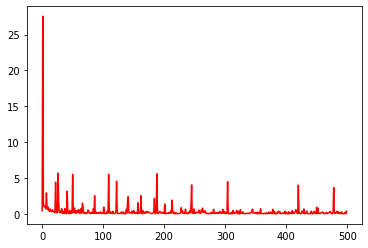

In [12]:
# Graphing losses
plt.plot(np.array([x.detach().numpy() for x in train_losses]), 'r')
plt.plot(np.array([x.detach().numpy() for x in val_losses]), 'b')

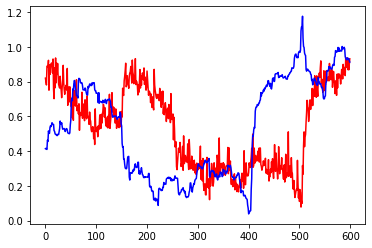

In [13]:
# MODEL PERFORMANCE - TRAINING PART
if not model:
  model=VolForecast(input_size=len(input_fields), seq_len=seq_len, horizon=horizon)
  model.load_state_dict(torch.load('./model'))
  
plot_model_performance_single_horizon(model, train_x, train_y, num_samples=600, horizon=horizon)

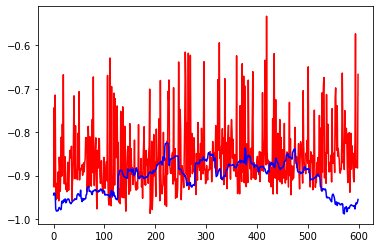

In [14]:
# MODEL'S PERFORMANCE - VALIDATION PART
if not model:
  model=VolForecast(input_size=len(input_fields), seq_len=seq_len, horizon=horizon)
  model.load_state_dict(torch.load('./model'))

plot_model_performance_single_horizon(model, val_x, val_y, num_samples=600, horizon=horizon)